In [1]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install wordcloud

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [3]:

%pip install googlesearch-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install tld

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [6]:
df=pd.read_csv('data/malicious_phish.csv')

print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement



### Lexical Features for URL Scanning:

1. **having_ip_address**: Checks if the URL contains an IP address, a common tactic used by attackers.
2. **abnormal_url**: Identifies URLs with potentially misleading or unusual structures via the WHOIS database.
3. **google_index**: Determines if the URL is indexed in Google Search Console, with legitimate sites generally being indexed.
4. **Count (sub-domains)**: Counts the number of dots in the URL; more than three suggests a higher likelihood of malicious intent.
5. **Count-www**: Checks for the presence of "www"; safe sites typically have one.
6. **count@**: Looks for the "@" symbol, which indicates ignored content before it.
7. **Count_dir**: Counts directories in the URL; multiple directories may indicate suspicion.
8. **Count_embed_domain**: Measures occurrences of "//"; many indicates embedded domains, often linked to malicious websites.
9. **Suspicious words**: Detects the presence of risky terms (e.g., “login,” “update”) in the URL. 
10. **Short_url**: Identifies URLs shortened by services (e.g., bit.ly), often used for deception.
11. **Count_https**: Flags URLs lacking HTTPS, indicating potential risks.
12. **Count_http**: Counts instances of "HTTP"; more than one suggests higher risk.
13. **Count%**: Measures percent signs (%) in URLs, related to space encoding; many signals danger.
14. **Count?**: Counts question marks (?) that denote query strings; more present raises suspicion.
15. **Count-**: Detects dashes (-) around brand names in URLs; often used to trick users.
16. **Count=**: Looks for equal signs (=), which indicate variable passing; seen as riskier.
17. **url_length**: Analyzes total length; longer URLs might obscure the domain.
18. **hostname_length**: Measures the length of the hostname for potential risks.
19. **First directory length**: Checks the length of the first directory in the URL.
20. **Length of top-level domains**: Short TLDs (2-3 characters) typically indicate safer URLs.
21. **Count_digits**: Counts digits in URLs, as malicious ones often include them.
22. **Count_letters**: Checks the number of letters; longer URLs can indicate malicious intent.

This feature extraction aims to analyze URLs for potential phishing and malware threats effectively.

In [7]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [8]:

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))



In [9]:
from googlesearch import search

def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))

def count_www(url):
    url.count('www')
    return url.count('www')


In [10]:
df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):
     
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))



In [11]:
def shortening_service(url):
    match = re.search(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      r'tr\.im|link\.zip\.net', url)
    if match:
        return 1
    else:
        return 0
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))


In [12]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23


In [13]:



def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['count-letters']= df['url'].apply(lambda i: letter_count(i))




In [14]:

from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [15]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld,tld_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,1,0,16,0,0,0,13,0,None,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,35,0,0,1,29,5,None,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,31,0,0,1,25,7,None,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,4,88,21,0,7,63,9,be,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,3,235,23,0,22,199,9,net,3


In [16]:
df.type.value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

**Exploratory Data Analysis (EDA)**

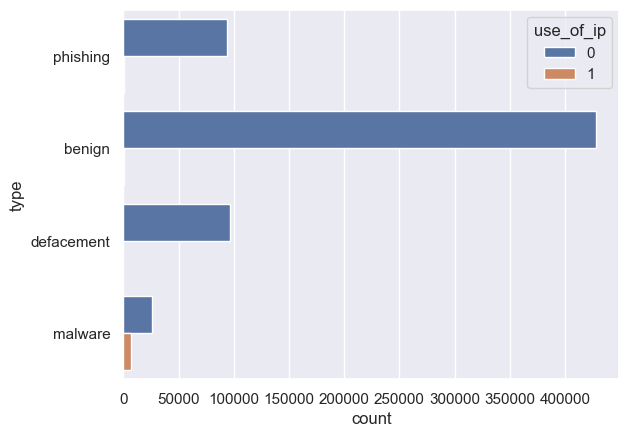

In [17]:
#Distribution use_of_ip
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")


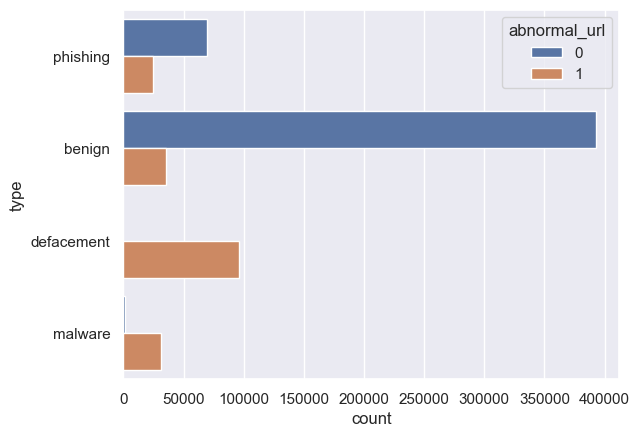

In [18]:
#Distribution of abnormal urls
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")


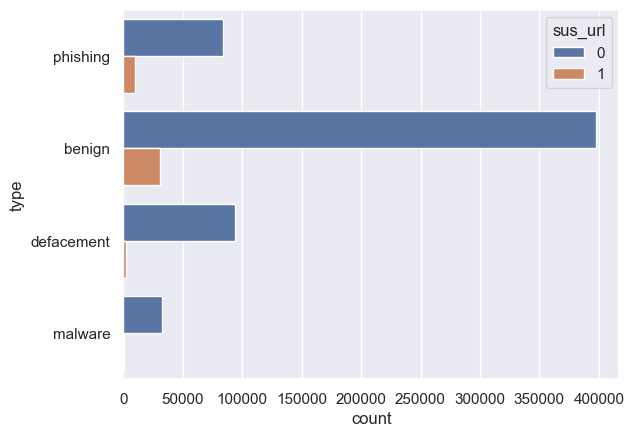

In [19]:
#Distribution of Suspiciou URLs
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")


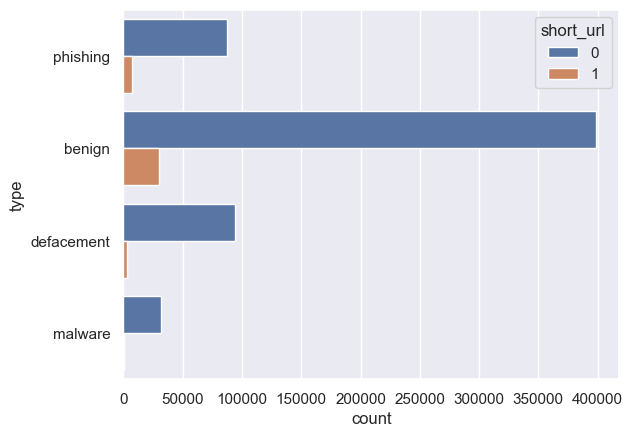

In [20]:
#Distribution of Short URLs
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")


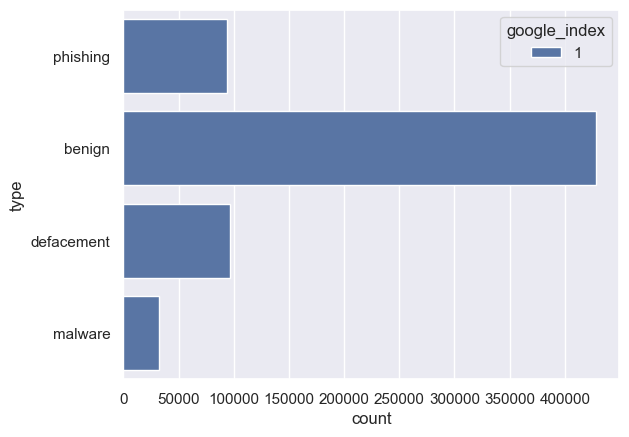

In [21]:
#Distribution of Google Index
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

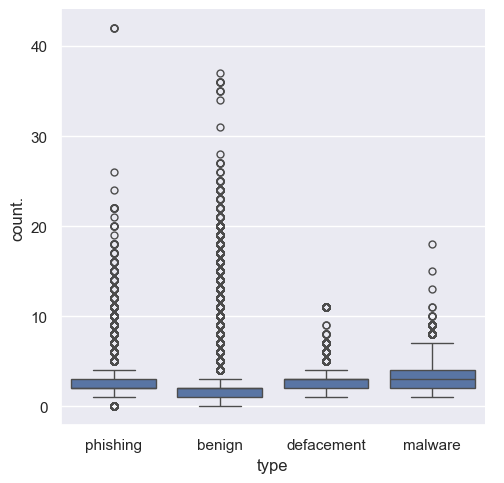

In [22]:
#Distribution of Count Of '.' Dot
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count.", kind="box", data=df)

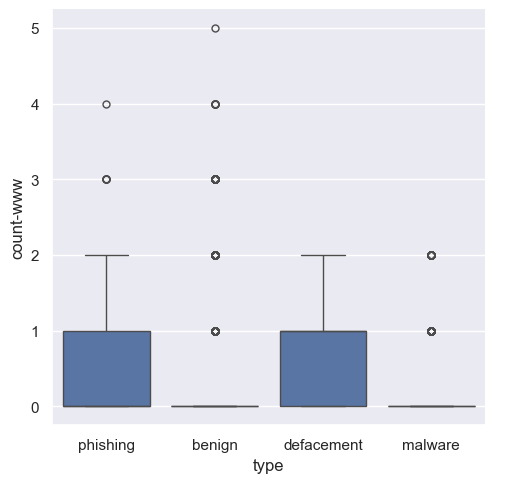

In [23]:
#Distribution Of Count Of WWW
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=df)

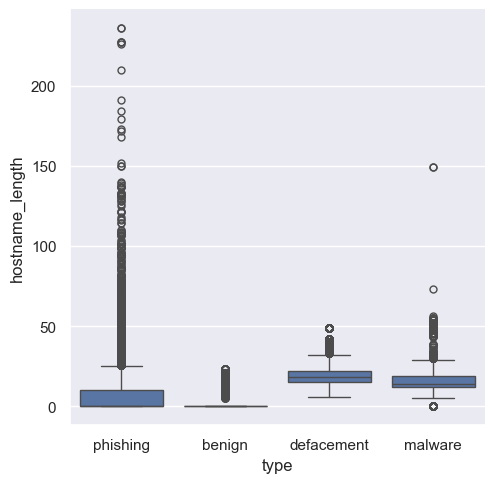

In [24]:
#Distribution of leangth of Hostname
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

**Label Encoding**

The next crucial step is to label and encode the target variable (type) into numerical categories (0, 1, 2, 3) for machine learning algorithms, which require numeric inputs.

In [25]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

Segregating Feature and Target variables

In [26]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

Training & Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [79]:
from sklearn.model_selection import train_test_split

# Load the full dataset
df = pd.read_csv('./data/malicious_phish.csv')

# Split into training and testing datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save the test set to a CSV file for testing
test_df.to_csv('./data/test_malicious_phish.csv', index=False)
print("Test dataset saved as './data/test_malicious_phish.csv'")


Test dataset saved as './data/test_malicious_phish.csv'


Model building

 We will build three tree-based ensemble machine learning models i.e., Light GBM,XGBoost, and Random Forest.

In [28]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)



              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.97      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.966


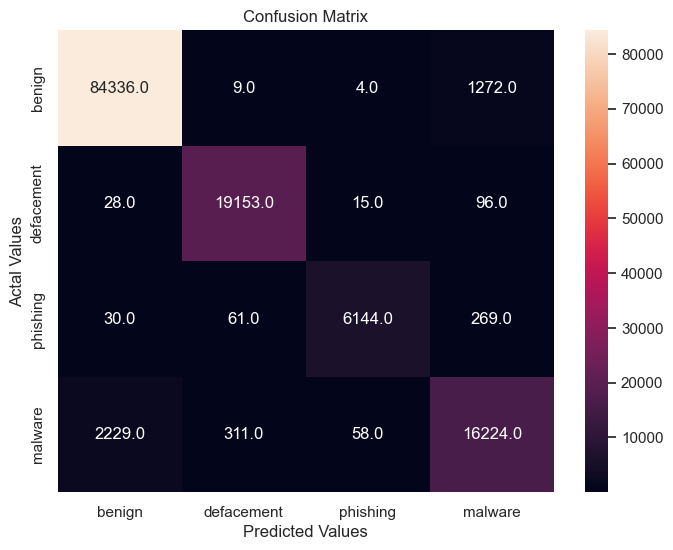

In [29]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [57]:
lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])


['benign' 'defacement' 'malware' 'phishing']


In [58]:
#XGboost
xgb_c = xgb.XGBClassifier(n_estimators= 100 ,use_label_encoder=False, eval_metric='mlogloss')
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))


score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)



C:\Users\SD BELALUDDIN17\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.97      0.92      0.94      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.962


In [63]:
import joblib
joblib.dump(xgb_c, "xgb_model.pkl")


['xgb_model.pkl']

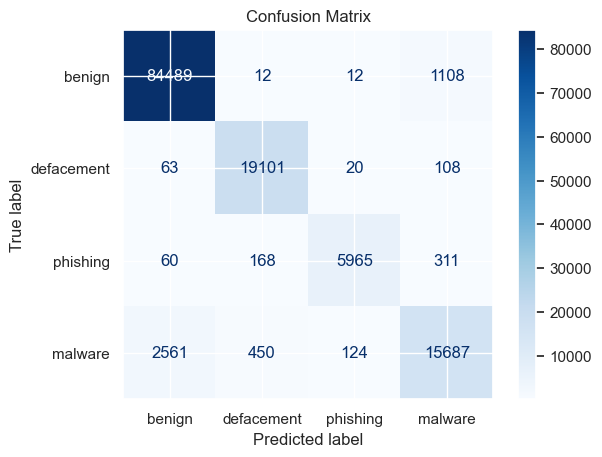

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define target names
target_names = ['benign', 'defacement', 'phishing', 'malware']

cm = confusion_matrix(y_test, y_pred_x)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [66]:
# Example: predict a single sample
sample = X.iloc[0].values.reshape(1, -1)
predicted_class = xgb_c.predict(sample)
print("Predicted:", lb_make.inverse_transform(predicted_class))


Predicted: ['phishing']


In [67]:
import joblib

joblib.dump(xgb_c, "xgb_model.pkl")
joblib.dump(lb_make, "label_encoder.pkl")


['label_encoder.pkl']

In [68]:
model = joblib.load("xgb_model.pkl")
label_encoder = joblib.load("label_encoder.pkl")


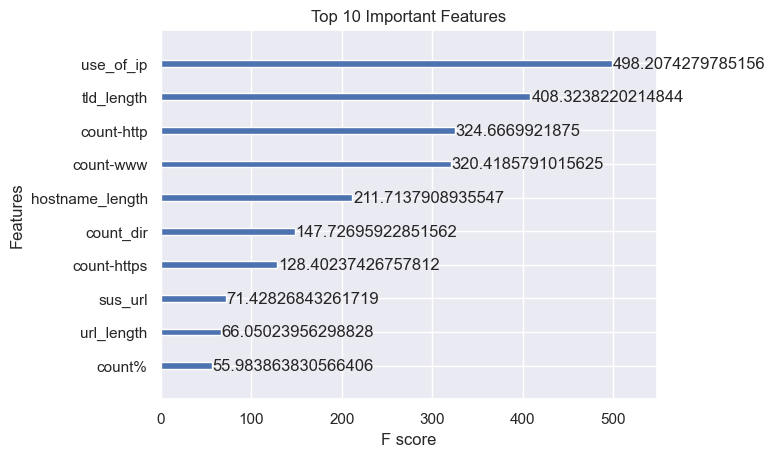

In [69]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_c, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features")
plt.show()


Prediction for URL 'https://chatgpt.com/c/67f8ca7b-f2e8-8011-b1a6-e96001e94aa8': phishing


In [52]:
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

y = df['type_code']


In [53]:
print(df.columns)


Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld', 'tld_length', 'type_code'],
      dtype='object')


In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5
)


In [56]:
# xgb_c = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
# xgb_c.fit(X_train, y_train)


In [32]:
# cm = confusion_matrix(y_test, y_pred_lgb)
# cm_df = pd.DataFrame(cm,
#                      index = ['benign', 'defacement','phishing','malware'], 
#                      columns = ['benign', 'defacement','phishing','malware'])
# plt.figure(figsize=(8,6))
# sns.heatmap(cm_df, annot=True,fmt=".1f")
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()

In [41]:
# Light GBM Classifier
from lightgbm import LGBMClassifier

# Remove the 'silent' parameter
lgb = LGBMClassifier(objective='multiclass', boosting_type='gbdt', n_jobs=5, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 21
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909712
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934324
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.90      0.93      6504
     malware       0.90      0.83      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130

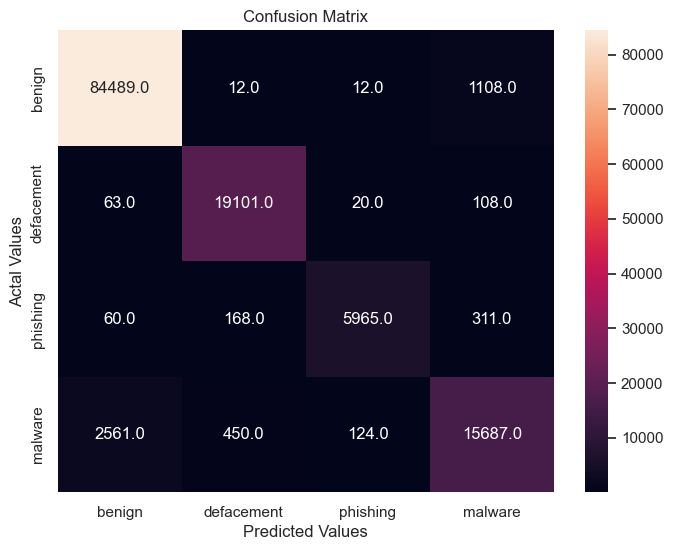

In [42]:
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

From the above result, it is evident that Random Forest shows the best performance in terms of test accuracy as it attains the highest accuracy of 96.6% with a higher detection rate for benign, defacement, phishing, and malware

<Axes: >

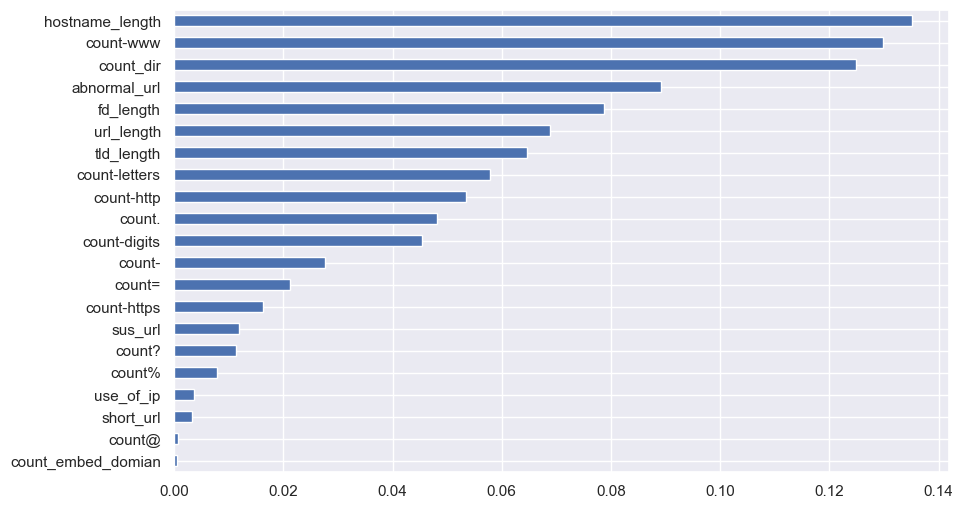

In [43]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

Model prediction

In [44]:
def main(url):
    
    status = []
    
    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    
    
    

    return status

In [45]:

def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))

    

def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Convert features_test to a DataFrame with the same column names as X_train
    features_test = pd.DataFrame([features_test], columns=X_train.columns)

    pred = lgb.predict(features_test)
    if int(pred[0]) == 0:
        return "SAFE"
    elif int(pred[0]) == 1:
        return "DEFACEMENT"
    elif int(pred[0]) == 2:
        return "PHISHING"
    elif int(pred[0]) == 3:
        return "MALWARE"
    

In [46]:
# predicting sample raw URLs

urls = [ "http://www.example.com/login",
    "https://secure-update-facebook.com",
    "http://192.168.0.1/badurl",
    "https://accounts.google.com",
    "https://chatgpt.com/c/67f8d30f-0c88-8011-9032-d210c6d715ce",
    "https://www.youtube.com/watch?v=PogM1ox6Es4&t=593s","en.wikipedia.org/wiki/North_Dakota"]

for url in urls:
     print(get_prediction_from_url(url))

MALWARE
MALWARE
PHISHING
MALWARE
PHISHING
MALWARE
SAFE
